In [102]:
from src.visualise import settings
from src.visualise.plot import plot_data
from src.data.paths import project_dir
from src.data.analysis import read_tiff_img, Circle, create_circular_mask
from src.data.detector import find_circle_hough_method, img_for_circle_detection

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from scipy.ndimage import center_of_mass
import re

from dataclasses import dataclass, field
from pathlib import Path

from copy import deepcopy

import tifffile 

import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

# Data structures

In [103]:
@dataclass(frozen=True)
class DetectorImage:
    image: np.ndarray
    path: Path

    @property
    def init_circle(self) -> Circle:
        return Circle(x=self.image.shape[0]//2, y=self.image.shape[1]//2, r=100)

@dataclass(frozen=True)
class DetectorData:
    raw: DetectorImage
    lv: DetectorImage
    det_no: int
    circle: Circle = field(default=Circle())

@dataclass(frozen=True)
class TupleXY:
    x: float
    y: float

@dataclass(frozen=True)
class CuttingParameters:
    foil_init_center: TupleXY
    foil_init_size: TupleXY
    cut_px: int = 100
    r_envelope_start: int = 150

# EBT3 Calibration

In [104]:
@dataclass
class Calibration:
    a0 : float = 0
    a1 : float = 0
    a2 : float = 0
    a3 : float = 0

    def __call__(self, x):
        return self.a0 + self.a1*x + self.a2*x**2 + self.a3*x**3

    def __repr__(self):
        result = f'f(x) = '
        first_item = True
        if self.a0 != 0:
            result += f'{self.a0}'
            if first_item:
                first_item = False
            else:
                result += ' +'
        if self.a1 != 0:
            if first_item:
                first_item = False
            else:
                result += ' +'
            result += f' {self.a1}*x'
        if self.a2 != 0:
            if first_item:
                first_item = False
            else:
                result += ' +'
            result += f' {self.a2}*x^2'
        if self.a3 != 0:
            if first_item:
                first_item = False
            else:
                result += ' +'
            result += f' {self.a3}*x^3'
        return result

ebt3_proton_calib_20Gy = Calibration(a1=9.62189, a3=78.75125)
ebt3_proton_calib_20Gy

f(x) =  9.62189*x + 78.75125*x^3

In [105]:
netOD_test = 0.28
ebt3_proton_calib_20Gy(netOD_test)

4.422876640000001

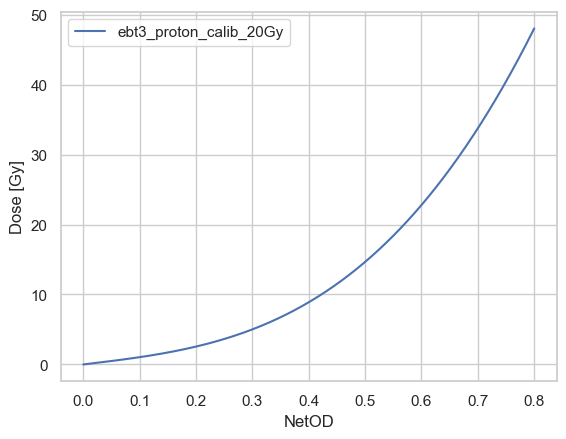

In [106]:
netOD_plot = np.linspace(0, 0.8, 800)

fig, ax = plt.subplots()
ax.plot(netOD_plot, ebt3_proton_calib_20Gy(netOD_plot), label='ebt3_proton_calib_20Gy')
ax.set_xlabel('NetOD')
ax.set_ylabel('Dose [Gy]')
ax.legend()

# EBT3 data loading

In [107]:
base_path = Path('C:\\Users\\grzanka\\OneDrive - ifj.edu.pl\\Projects\\MB_foils\\')
base_path.exists()

True

In [108]:
image_path = base_path / '2024-04-22_PB_with_EBT_4Gy' / '2024-04-23_EBT3' / 'skan108.tif'
image_path.exists()

True

In [109]:
def net_optical_density(image: np.ndarray, channel_no : int = 0) -> np.ndarray:
    bg_r = 42804.451 
    bg_g = 44273.485
    bg_b = 27929.477 
    bg = [bg_r, bg_g, bg_b]
    return np.log10(bg[channel_no] / image[:, :, channel_no])

In [110]:
def ebt3_dose_Gy(image: np.ndarray, calib: Calibration = ebt3_proton_calib_20Gy, channel_no : int = 0) -> np.ndarray:
    return calib(net_optical_density(image, channel_no))

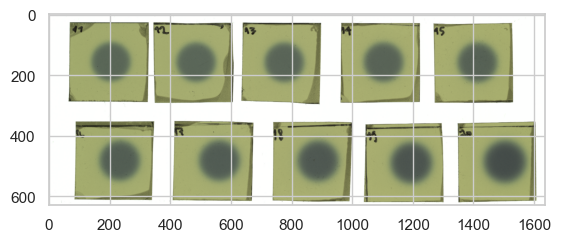

In [111]:
im = tifffile.imread(image_path)
im.shape, im.dtype
plt.imshow(im / im.max(), cmap='gray')

In [112]:
net_optical_density(im).min(), net_optical_density(im).max()

(-0.1849843725036639, 0.8612261930909926)

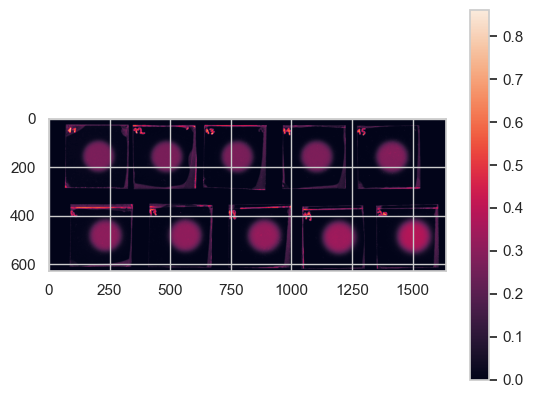

In [113]:
plt.imshow(np.where(net_optical_density(im) < 0, 0, net_optical_density(im)))
plt.colorbar()

## Single foil tests

### Foil selection

In [114]:
foil_init_center = (150, 200)
foil_init_dx = 120
foil_init_dy = 120
foil_cut1 = im[foil_init_center[0]-foil_init_dx:foil_init_center[0]+foil_init_dx,
             foil_init_center[1]-foil_init_dy:foil_init_center[1]+foil_init_dy]

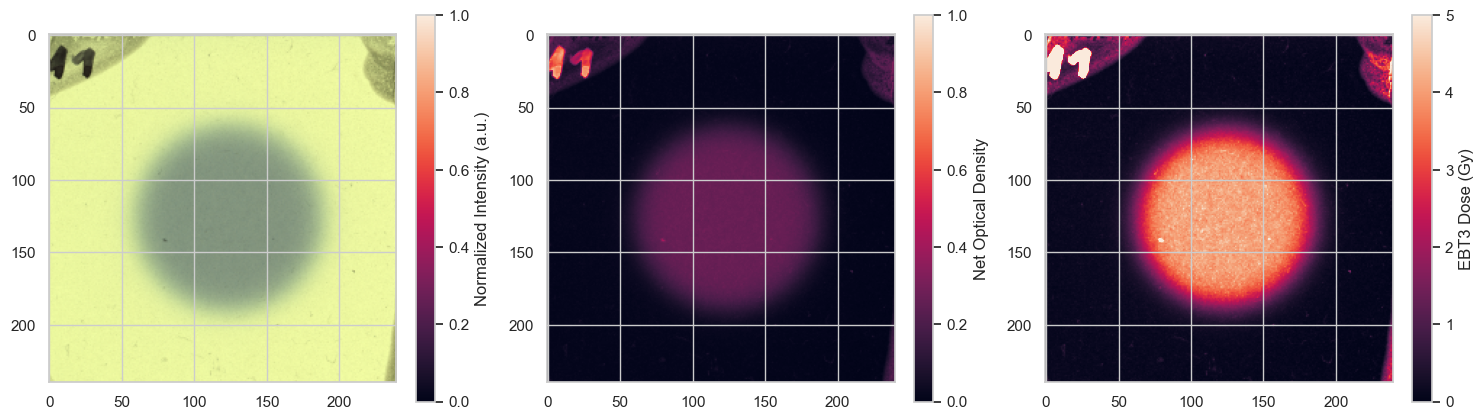

In [115]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
im1 = axs[0].imshow(foil_cut1 / foil_cut1.max(), vmin=0, vmax=1.0)
im2 = axs[1].imshow(net_optical_density(foil_cut1), vmin=0, vmax=1.0)
im3 = axs[2].imshow(ebt3_dose_Gy(foil_cut1), vmin=0, vmax=5)

fig.colorbar(im1, label='Normalized Intensity (a.u.)', fraction=0.05)
fig.colorbar(im2, label='Net Optical Density', fraction=0.05)
fig.colorbar(im3, label='EBT3 Dose (Gy)', fraction=0.05)

plt.tight_layout()

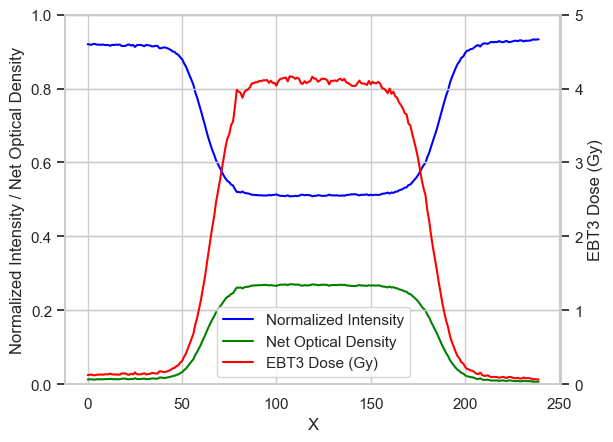

In [116]:
fig, ax = plt.subplots()
x_slice = slice(100,150)
ax.plot((foil_cut1 / foil_cut1.max())[x_slice, :, 0].mean(axis=0), label='Normalized Intensity', color='blue')
ax.plot(net_optical_density(foil_cut1)[x_slice, :].mean(axis=0), label='Net Optical Density', color='green')
ax_twin = ax.twinx()
ax_twin.plot(ebt3_dose_Gy(foil_cut1)[x_slice, :].mean(axis=0), label='EBT3 Dose (Gy)', color='red')
ax.set_xlabel('X')
ax.set_ylabel('Normalized Intensity / Net Optical Density')
ax_twin.set_ylabel('EBT3 Dose (Gy)')
ax.set_ylim(0, 1)
ax_twin.set_ylim(0, 5)
# legend for ax and ax_twin
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_twin.get_legend_handles_labels()
ax_twin.legend(lines + lines2, labels + labels2, loc=0)


### Detector cutting

In [117]:
dpi = 300
ebt_px_to_mm = 25.4 / dpi
ebt_px_to_mm

0.08466666666666667

r_envelope = 77.55, vmax = 4.87


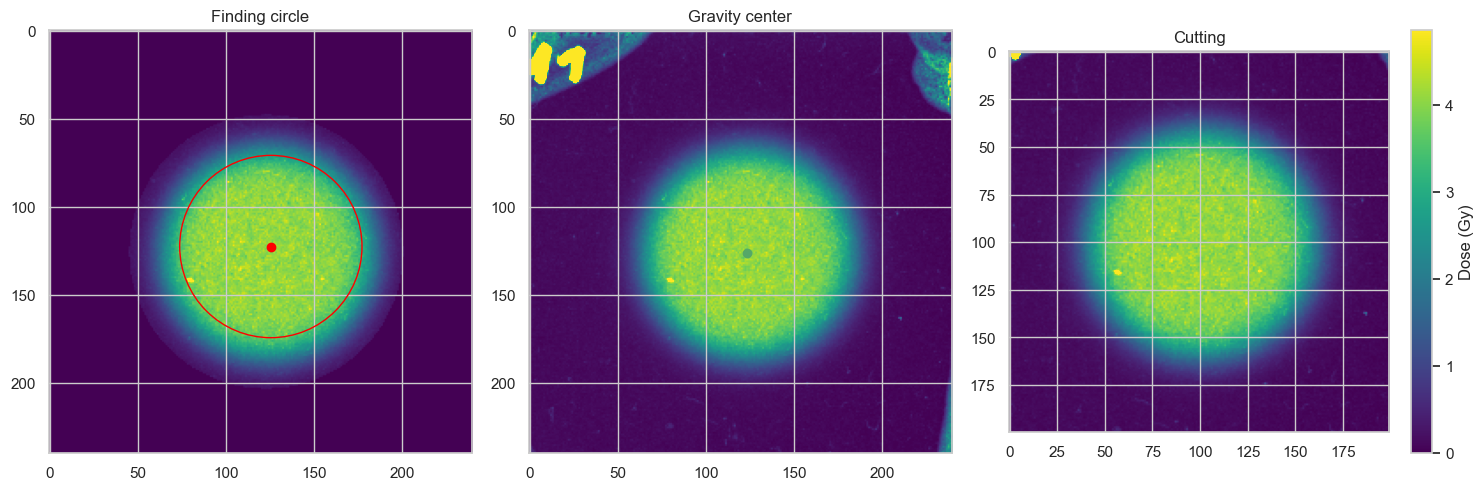

In [118]:
data = ebt3_dose_Gy(foil_cut1)[:,:]

# finding circle
data_for_circle = data.copy()
lv_for_detect = img_for_circle_detection(data_for_circle, nsigma=1)
circle = find_circle_hough_method(lv_for_detect, max_radius=180, min_radius=50)
vmin =  0
r_envelope = min(1.5*circle.r, 150)
mask = create_circular_mask(data_for_circle, Circle(x=circle.x, y=circle.y, r=r_envelope))
vmax = 1.1*np.percentile(data_for_circle[mask], 99)
data_for_circle[~mask] = 0
print(f"r_envelope = {r_envelope:.2f}, vmax = {vmax:.2f}")

# finding center of mass
data_for_cm = data_for_circle.copy()
cm = center_of_mass(data_for_cm)

# detector cutting
cut_px = 100
low_x = int(max(0, cm[0] - cut_px))
high_x = int(min(data.shape[0], cm[0] + cut_px))
low_y = int(max(0, cm[1] - cut_px))
high_y = int(min(data.shape[1], cm[1] + cut_px))
data_cut = data[low_x:high_x, low_y:high_y]

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

im1 = axs[0].imshow(data_for_circle, cmap='viridis', vmin=0, vmax=vmax)
axs[0].plot(circle.y, circle.x, 'o', color='red')
axs[0].add_artist(
    plt.Circle(xy=(circle.y, circle.x),
               radius=circle.r,
               color='red',
               fill=False,
               transform=axs[0].transData))
axs[0].set_title('Finding circle')

im2 = axs[1].imshow(data, cmap='viridis', vmin=0, vmax=vmax)
axs[1].scatter(cm[1], cm[0], color='g');
axs[1].set_title('Gravity center')

im3 = axs[2].imshow(data_cut, cmap='viridis', vmin=0, vmax=vmax)
axs[2].set_title('Cutting')

#fig.colorbar(im1, label='Dose [Gy]', fraction=0.05)
#fig.colorbar(im2, label='Net Optical Density', fraction=0.05)
fig.colorbar(im3, label='Dose (Gy)', fraction=0.05)

plt.tight_layout()

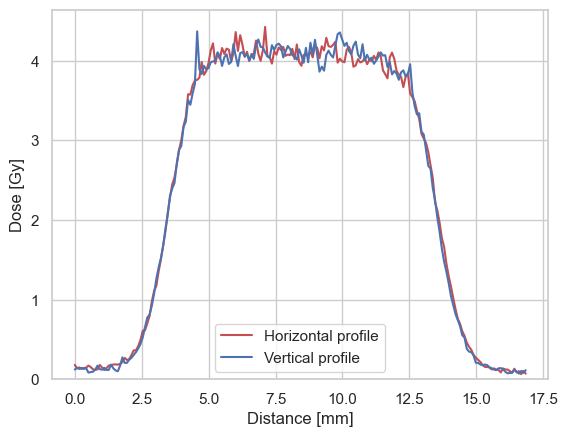

In [119]:
# plot horizontal and vertical profiles
profile_dx = 5
# plot as function of distance in mm, assuming 300dpi
res = 300
y_data = np.mean(data_cut[data_cut.shape[0]//2 - profile_dx//2:data_cut.shape[0]//2 + profile_dx//2,:], axis=0)
y_data_2 = np.mean(data_cut[:, data_cut.shape[1]//2 - profile_dx//2:data_cut.shape[1]//2 + profile_dx//2], axis=1)
x_mm = np.arange(y_data.shape[0]) / res * 25.4
plt.plot(x_mm, y_data , color='r', label='Horizontal profile')
plt.plot(x_mm, y_data_2, color='b', label='Vertical profile')
plt.ylim(0, None)
plt.xlabel('Distance [mm]')
plt.ylabel('Dose [Gy]')
plt.legend();

## All foils

In [120]:
def inital_cut( im: np.ndarray, params: CuttingParameters) -> np.ndarray:
    low_x = int(max(0, params.foil_init_center.x - params.foil_init_size.x))
    high_x = int(min(im.shape[0], params.foil_init_center.x + params.foil_init_size.x))
    low_y = int(max(0, params.foil_init_center.y - params.foil_init_size.y))
    high_y = int(min(im.shape[1], params.foil_init_center.y + params.foil_init_size.y))
    cut_ebt3 = im[low_y:high_y, low_x:high_x]
    data = ebt3_dose_Gy(cut_ebt3)[:,:]
    return data

In [121]:
def cut_detector_circle(dose_cut_Gy: np.ndarray, max_radius: int = 180, min_radius : int = 50, nsigma: float = 1.) -> np.ndarray:
    lv_for_detect = img_for_circle_detection(dose_cut_Gy, nsigma=nsigma)
    circle = find_circle_hough_method(lv_for_detect, max_radius=max_radius, min_radius=min_radius)
    return circle

In [122]:
def circle_mask(dose_cut_Gy: np.ndarray, circle : Circle, params: CuttingParameters) -> np.ndarray:
    r_envelope = min(1.5*circle.r, params.r_envelope_start)
    mask = create_circular_mask(dose_cut_Gy, Circle(x=circle.x, y=circle.y, r=r_envelope))
    return mask

In [123]:
def cm_for_plotting(dose_cut_Gy: np.ndarray, mask: np.ndarray) -> np.ndarray:
    data = dose_cut_Gy.copy()
    data[~mask] = 0
    cm = center_of_mass(data)
    return cm

In [124]:
def vmax_for_plotting(dose_cut_Gy: np.ndarray, cm: np.ndarray, factor: float = 1.1, percentile: float = 99) -> float:
    vmax = factor*np.percentile(dose_cut_Gy[mask], percentile)
    return vmax

In [125]:
def cut_detector(dose_cut_Gy: np.ndarray, cm: np.ndarray, params: CuttingParameters) -> np.ndarray:
    low_x = max(int(cm[0] - params.cut_px),0)
    high_x = min(int(cm[0] + params.cut_px), dose_cut_Gy.shape[1])
    low_y = max(int(cm[1] - params.cut_px),0)
    high_y = max(int(cm[1] + params.cut_px), dose_cut_Gy.shape[0])
    data_cut = dose_cut_Gy[low_y:high_y, low_x:high_x]
    return data_cut.copy()

In [126]:
def cut_detector_all_steps(im: np.ndarray, params: CuttingParameters) -> tuple[np.ndarray, Circle, np.ndarray, float]:
    dose_cut_Gy = inital_cut(im, params)
    circle = cut_detector_circle(dose_cut_Gy)
    mask = circle_mask(dose_cut_Gy, circle, params)
    cm = cm_for_plotting(dose_cut_Gy, mask)
    vmax = vmax_for_plotting(dose_cut_Gy, cm)
    data_cut = cut_detector(dose_cut_Gy, cm, params)
    return data_cut, circle, cm, vmax, dose_cut_Gy

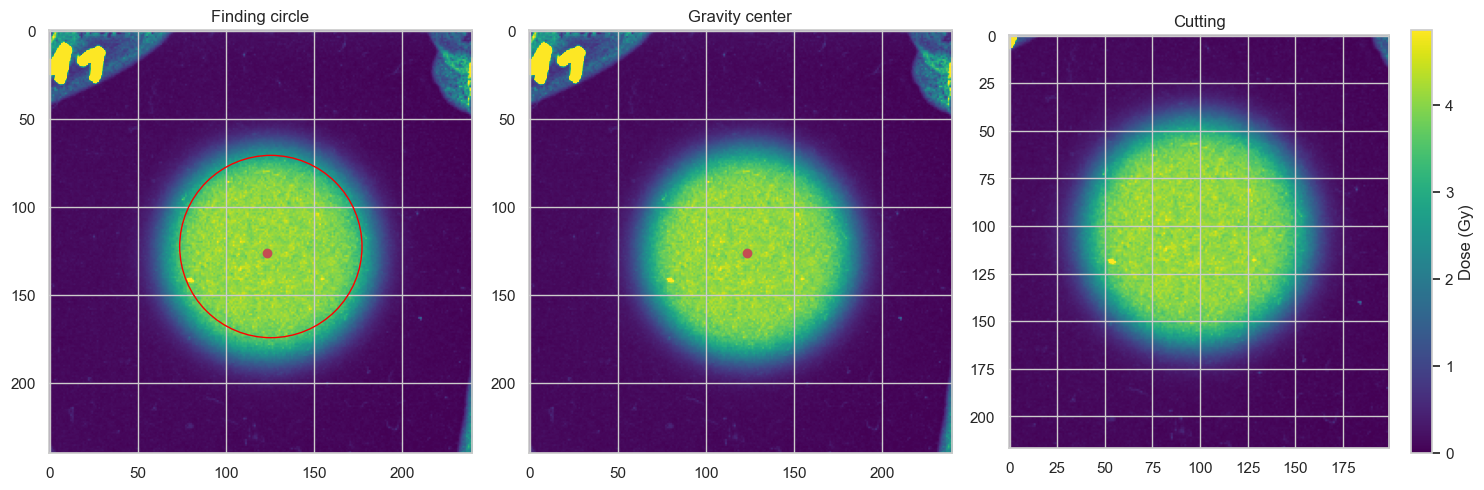

In [130]:
params = CuttingParameters(foil_init_center=TupleXY(200, 150), foil_init_size=TupleXY(120, 120), cut_px=100, r_envelope_start=150)
data_cut, circle, cm, vmax, dose_cut_Gy = cut_detector_all_steps(im, params)

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

im1 = axs[0].imshow(dose_cut_Gy, cmap='viridis', vmin=0, vmax=vmax)
axs[0].scatter(cm[1], cm[0], color='r');
axs[0].add_artist(
    plt.Circle(xy=(circle.y, circle.x),
               radius=circle.r,
               color='red',
               fill=False,
               transform=axs[0].transData))
axs[0].set_title('Finding circle')

im2 = axs[1].imshow(dose_cut_Gy, cmap='viridis', vmin=0, vmax=vmax)
axs[1].scatter(cm[1], cm[0], color='r');
axs[1].set_title('Gravity center')

im3 = axs[2].imshow(data_cut, cmap='viridis', vmin=0, vmax=vmax)
axs[2].set_title('Cutting')

fig.colorbar(im3, label='Dose (Gy)', fraction=0.05)

plt.tight_layout()

In [128]:
ebt3_cutting_params = {
    11 : CuttingParameters(foil_init_center=TupleXY(150, 200), foil_init_size=TupleXY(120, 120)),
}

# OSL MB

In [129]:
#det1_im = np.load(Path('C:\\Users\\Legion\\OneDrive - ifj.edu.pl\\Projects\\MB_foils\\2024-04-22\\mb_det1.npy'))
det1_im = np.load(project_dir / 'data' / 'raw' / '2024-04-22' / 'mb_det1.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\grzanka\\workspace\\osl_mb_foils\\data\\raw\\2024-04-22\\mb_det1.npy'

In [ ]:
plt.imshow(det1_im, cmap='gray')

In [ ]:
from scipy.ndimage import center_of_mass
det1_cm = center_of_mass(det1_im)
print(f"original data (shape {data.shape}) CM = ({det1_cm[0]:.2f}, {det1_cm[1]:.2f})")

cut_px = 110
det1_data_cut = det1_im[int(det1_cm[0])-cut_px:int(det1_cm[0])+cut_px, int(det1_cm[1])-cut_px:int(det1_cm[1])+cut_px]
det1_cm_cut = center_of_mass(det1_data_cut)
print(f"1st cut data CM = ({det1_cm_cut[0]:.2f}, {det1_cm_cut[1]:.2f}), shape {det1_data_cut.shape}")

cut_px = 105
det1_data_cut = det1_data_cut[int(det1_cm_cut[0])-cut_px:int(det1_cm_cut[0])+cut_px, int(det1_cm_cut[1])-cut_px:int(det1_cm_cut[1])+cut_px]
det1_cm_cut = center_of_mass(det1_data_cut)
print(f"2nd cut data CM = ({det1_cm_cut[0]:.2f}, {det1_cm_cut[1]:.2f}), shape {det1_data_cut.shape}")

cut_px = 100
det1_data_cut = det1_data_cut[int(det1_cm_cut[0])-cut_px:int(det1_cm_cut[0])+cut_px, int(det1_cm_cut[1])-cut_px:int(det1_cm_cut[1])+cut_px]
det1_cm_cut = center_of_mass(det1_data_cut)
print(f"3rd cut data CM = ({det1_cm_cut[0]:.2f}, {det1_cm_cut[1]:.2f}), shape {det1_data_cut.shape}")

# plot center of mass
plt.imshow(det1_data_cut, cmap='gray')
plt.scatter(det1_cm_cut[1], det1_cm_cut[0], color='r');

In [ ]:
# plot horizontal and vertical profiles
profile_dx = 50
# plot as function of distance in mm, assuming 300dpi
px_to_mm = 0.07211249531663806 
mb_y_data = np.mean(det1_data_cut[det1_data_cut.shape[0]//2 - profile_dx//2:det1_data_cut.shape[0]//2 + profile_dx//2,:], axis=0)
mb_y_data_2 = np.mean(det1_data_cut[:, det1_data_cut.shape[1]//2 - profile_dx//2:det1_data_cut.shape[1]//2 + profile_dx//2], axis=1)
mb_x_mm = np.arange(mb_y_data.shape[0]) * px_to_mm
mb_y_data_mean = np.mean(mb_y_data, where=(mb_x_mm>4)&(mb_x_mm<10))
mb_y_data_2_mean = np.mean(mb_y_data_2, where=(mb_x_mm>4)&(mb_x_mm<10))
plt.plot(mb_x_mm, mb_y_data / mb_y_data_mean, color='r')
plt.plot(mb_x_mm, mb_y_data_2 / mb_y_data_mean, color='b')
plt.ylim(0, None)

# all of them

In [ ]:
plt.plot(x_mm, y_data / y_data_mean, color='g')
#plt.plot(x_mm, y_data_2 / y_data_mean, color='b')
plt.plot(mb_x_mm, mb_y_data / mb_y_data_mean, color='r')
#plt.plot(mb_x_mm, mb_y_data_2 / mb_y_data_mean, color='b')
plt.ylim(0, None)

In [ ]:
plt.plot(x_mm, y_data / y_data_mean, color='g')
# apply median filter on mb_y_data
mb_y_data_filtered = ndi.median_filter(mb_y_data, size=15)
plt.plot(mb_x_mm, mb_y_data_filtered / mb_y_data_mean, color='r')
plt.ylim(0, None)

## EBT3 radial profile

In [ ]:
plt.imshow(data_cut, cmap='viridis')
plt.scatter(cm_cut[1], cm_cut[0], color='r');

In [ ]:
r = []
v = []
for i in range(data_cut.shape[0]):
    for j in range(data_cut.shape[1]):
        v_to_cm = ((i - cm_cut[0])**2 + (j - cm_cut[1])**2)**0.5
        r.append(v_to_cm)
        v.append(data_cut[i, j])
df_r = pd.DataFrame({'r': r, 'v': v})
df_r['r_mm'] = df_r['r'] * ebt_px_to_mm 
df_r['r_mm_round'] = df_r['r_mm'].round(2)
df_r['v_norm'] = df_r['v'] / df_r['v'][df_r['r_mm'] < 3].mean()
df_r


In [ ]:
df_r.plot(x='r_mm_round', y='v', kind='scatter')

In [ ]:
df_r.groupby('r_mm_round').mean().plot(y='v')

## MB radial profile

In [ ]:
plt.imshow(det1_data_cut, cmap='viridis')
plt.scatter(det1_cm_cut[1], det1_cm_cut[0], color='r');

In [ ]:
r = []
v = []
for i in range(det1_data_cut.shape[0]):
    for j in range(det1_data_cut.shape[1]):
        v_to_cm = ((i - det1_cm_cut[0])**2 + (j - det1_cm_cut[1])**2)**0.5
        r.append(v_to_cm)
        v.append(det1_data_cut[i, j])
df_r_mb = pd.DataFrame({'r': r, 'v': v})
df_r_mb['r_mm'] = df_r_mb['r'] * px_to_mm 
df_r_mb['r_mm_round'] = df_r_mb['r_mm'].round(2)
df_r_mb['v_norm'] = df_r_mb['v'] / df_r_mb['v'][df_r_mb['r_mm'] < 3].mean()
df_r_mb


In [ ]:
df_r_mb.plot(x='r_mm_round', y='v_norm', kind='scatter')

In [ ]:
df_r_mb.groupby('r_mm_round').mean().plot(y='v_norm')

# OSL vs MB profile

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
df_r_mb.groupby('r_mm_round').mean().plot(y='v_norm', ax=ax, label='MB')
df_r.groupby('r_mm_round').mean().plot(y='v_norm', ax=ax, label='EBT')
plt.xlabel('r [mm]')
plt.ylim(0, 1.2)